In [509]:
import sklearn
import time

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pylab as plt
import catboost as cat

from xgboost import XGBClassifier
from tqdm.notebook import tqdm_notebook

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [510]:
def get_memory_usage(df):
    return f'{round(df.memory_usage().sum() / 1024 / 1024, 2)} mb'

def get_dataset(path, size=10000, test_size=0.3):
    t = pd.read_csv(path, chunksize=size, header=None)

    for data in t:
        print('Memory usage of dense:', get_memory_usage(data))
        print('Memory usage of sparse:', 
              get_memory_usage(pd.SparseDataFrame(data)))
        

        y = data[0]
        x = data[list(range(1, len(data.columns)))]

        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size
        )

        return x_train, x_test, y_train, y_test
    
def to_sparse(*args):
    new = []
    
    for mat in args:
        new.append(sparse.csr_matrix(mat))
        
    return tuple(new)

In [511]:
def xgb_fit_eval(x_train, x_test, y_train, y_test):
    train = xgb.DMatrix(x_train, y_train)
    test = xgb.DMatrix(x_test, y_test)
    
    curr_time = time.time()
    model = xgb.train(params={'silent': 1,
                              'objective': 'binary:logistic',
                              'n_estimators': 100},
                      dtrain=train, 
                      verbose_eval=0)
    
    end_time = (time.time() - curr_time) / 100
    
    predict = roc_auc_score(y_test, model.predict(test))
    
    return predict, end_time


def xgb_fit_eval_colsample(x_train, x_test, y_train, y_test):
    train = xgb.DMatrix(x_train, y_train)
    test = xgb.DMatrix(x_test, y_test)
    
    curr_time = time.time()
    model = xgb.train(params={'silent': 1,
                          'objective': 'binary:logistic',
                          'n_estimators': 100,
                          'colsample_bytree': 0.5},
                      dtrain=train, 
                      verbose_eval=0)
    
    end_time = (time.time() - curr_time) / 100
    
    predict = roc_auc_score(y_test, model.predict(test))
    
    return predict, end_time


def model_fit_eval(x_train, x_test, y_train, y_test, model_type=None):
    
    curr_time = time.time()
    model = model_type(n_estimators=100)
    model.fit(x_train, y_train)
    
    end_time = (time.time() - curr_time) / 100
    
    predict = roc_auc_score(y_test, model.predict(x_test))
    
    return predict, end_time

In [512]:
def experiment(x_train, x_test, y_train, y_test):
    
    xgb_res = []
    xgbc_res = []
    ada_res = []
    gbc_res = []
    rfc_res = []
    
    for i in tqdm_notebook([0.1, 0.3, 0.5, 0.7, 1]):
        x_t, y_t = x_train[:int(x_train.shape[0] * i)], y_train[:int(y_train.shape[0] * i)]
        
        xgb_res.append([x_t.shape[0], xgb_fit_eval(x_t, x_test, y_t, y_test)])
        
        xgbc_res.append([x_t.shape[0], xgb_fit_eval_colsample(x_t, x_test, y_t, y_test)])
        
        ada_res.append([x_t.shape[0], model_fit_eval(x_t, x_test, y_t, y_test, 
                                 model_type=AdaBoostClassifier)])
        
        gbc_res.append([x_t.shape[0], model_fit_eval(x_t, x_test, y_t, y_test, 
                                 model_type=GradientBoostingClassifier)])
        
        rfc_res.append([x_t.shape[0], model_fit_eval(x_t, x_test, y_t, y_test, 
                                 model_type=RandomForestClassifier)])
        
    return xgb_res, xgbc_res, ada_res, gbc_res, rfc_res


def plot_results(xgb_res, xgbc_res, ada_res, gbc_res, rfc_res):
    plt.figure(figsize=(24, 10))
    
    plt.subplot(121)
    plt.title('Comparison of the quality of algorithms')
    
    plt.plot([i for i, (j,k) in xgb_res], 
             [j for i, (j,k) in xgb_res], 
             label='xgboost')
    
    plt.plot([i for i, (j,k) in xgbc_res], 
             [j for i, (j,k) in xgbc_res], 
             label='xgboost (colsample=0.5)')
    
    plt.plot([i for i, (j,k) in ada_res], 
             [j for i, (j,k) in ada_res],
             label='adaboost')
    
    plt.plot([i for i, (j,k) in gbc_res], 
             [j for i, (j,k) in gbc_res], 
             label='sklearn gb')
    
    plt.plot([i for i, (j,k) in rfc_res], 
             [j for i, (j,k) in rfc_res], 
             label='sklearn rf')
    
    plt.xlabel('Number of Training Examples')
    plt.ylabel('ROC_AUC')
    plt.legend()
    
    plt.subplot(122)
    plt.title('Comparison of the runtime of algorithms')
    
    plt.plot([i for i, (j,k) in xgb_res], 
             [k for i, (j,k) in xgb_res], 
             label='xgboost')
    
    plt.plot([i for i, (j,k) in xgbc_res], 
             [k for i, (j,k) in xgbc_res], 
             label='xgboost (colsample=0.5)')
    
    plt.plot([i for i, (j,k) in ada_res], 
             [k for i, (j,k) in ada_res],
             label='adaboost')
    
    plt.plot([i for i, (j,k) in gbc_res], 
             [k for i, (j,k) in gbc_res], 
             label='sklearn gb')
    
    plt.plot([i for i, (j,k) in rfc_res], 
             [k for i, (j,k) in rfc_res], 
             label='sklearn rf')
    
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Time Per Tree (sec)')
    plt.legend()
    
    plt.show()

In [513]:
def sparse_vs_dense(x_train, x_test, y_train, y_test):
    
    sparse = []
    dense = []
    
    for i in tqdm_notebook([0.1, 0.3, 0.5, 0.7, 1]):
        x_t, y_t = x_train[:int(x_train.shape[0] * i)], y_train[:int(y_train.shape[0] * i)]
        
        dense.append([x_t.shape[0], 
                      xgb_fit_eval(x_t, x_test, y_t, y_test)])
        sparse.append([x_t.shape[0], 
                       xgb_fit_eval(*to_sparse(x_t, x_test), y_t, y_test)])
        
    return dense, sparse

def plot_sparse_vs_dense(dense, sparse):
    plt.figure(figsize=(24, 10))
    
    plt.subplot(121)
    plt.title('Comparison of the quality of algorithms')
    
    plt.plot([i for i, (j,k) in dense], 
             [j for i, (j,k) in dense], 
             label='dense')
    
    plt.plot([i for i, (j,k) in sparse], 
             [j for i, (j,k) in sparse],
             label='sparse')
    
    plt.xlabel('Number of Training Examples')
    plt.ylabel('ROC_AUC')
    plt.legend()
    
    plt.subplot(122)
    plt.title('Comparison of the runtime of algorithms')
    
    plt.plot([i for i, (j,k) in dense], 
             [k for i, (j,k) in dense], 
             label='dense')
    
    plt.plot([i for i, (j,k) in sparse], 
             [k for i, (j,k) in sparse],
             label='sparse')
    
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Time Per Tree (sec)')
    plt.legend()
    
    plt.show()

## HIGGS

In [514]:
x_train, x_test, y_train, y_test = get_dataset('HIGGS.csv', size=100000)

Memory usage of dense: 22.13 mb
Memory usage of sparse: 22.13 mb


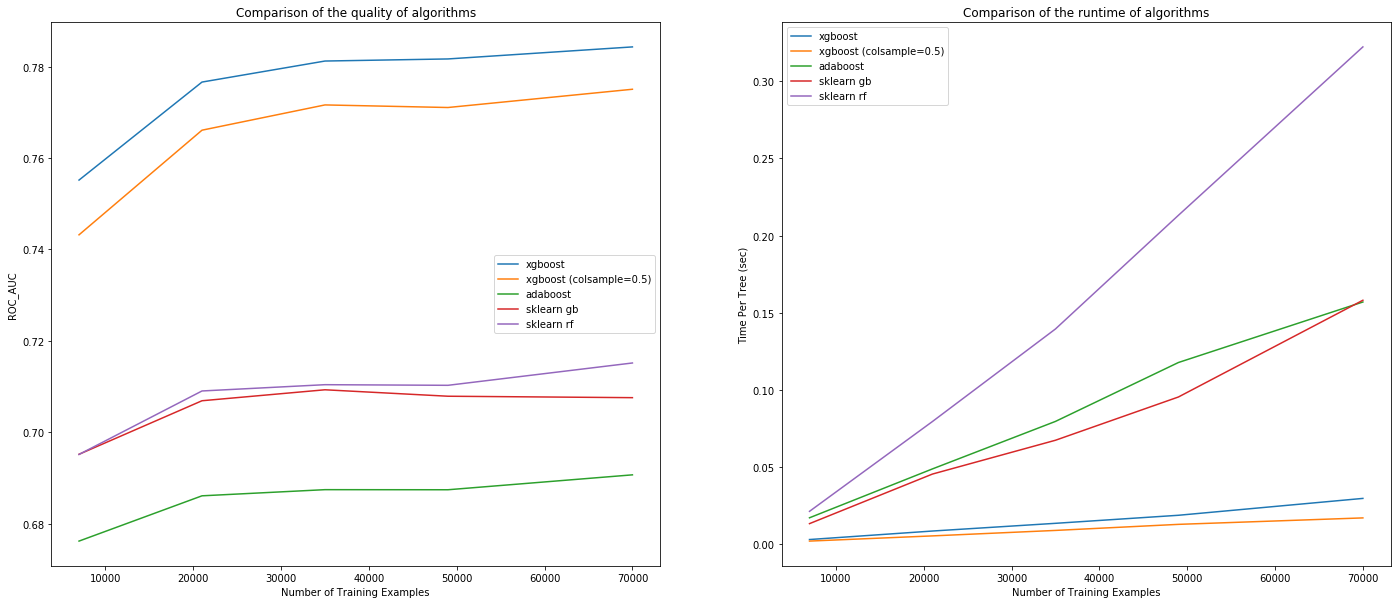

In [515]:
plot_results(*experiment(x_train, x_test, y_train, y_test))

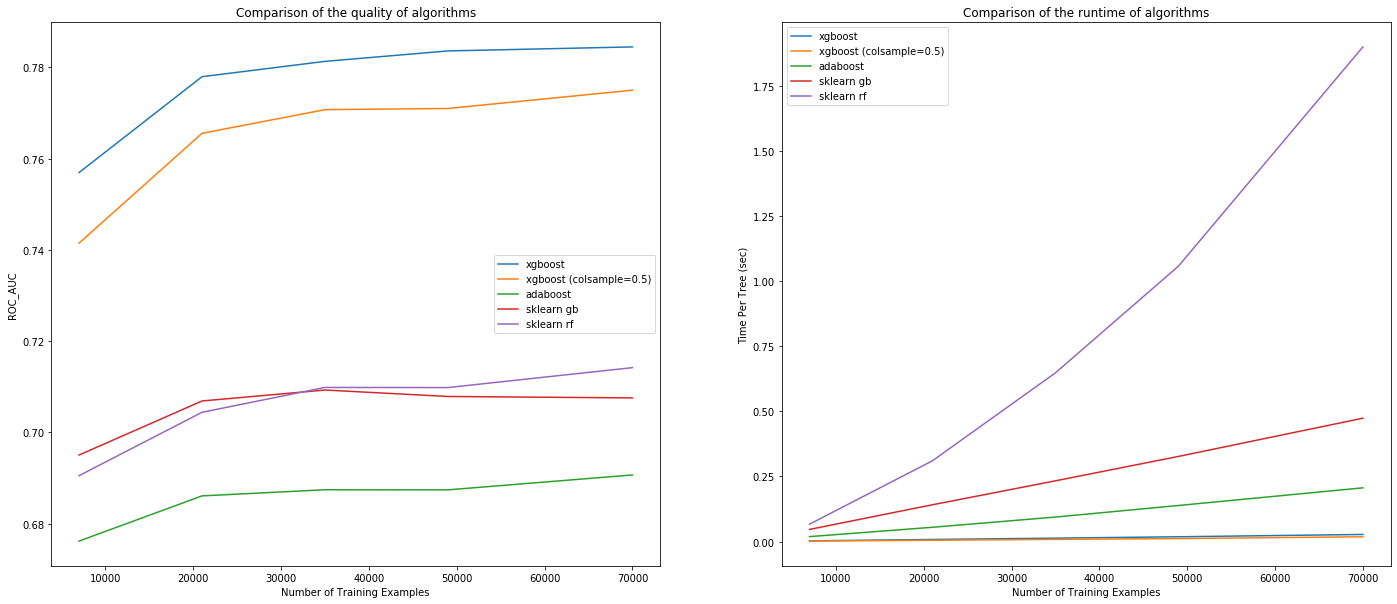

In [516]:
plot_results(*experiment(*to_sparse(x_train, x_test), y_train, y_test))

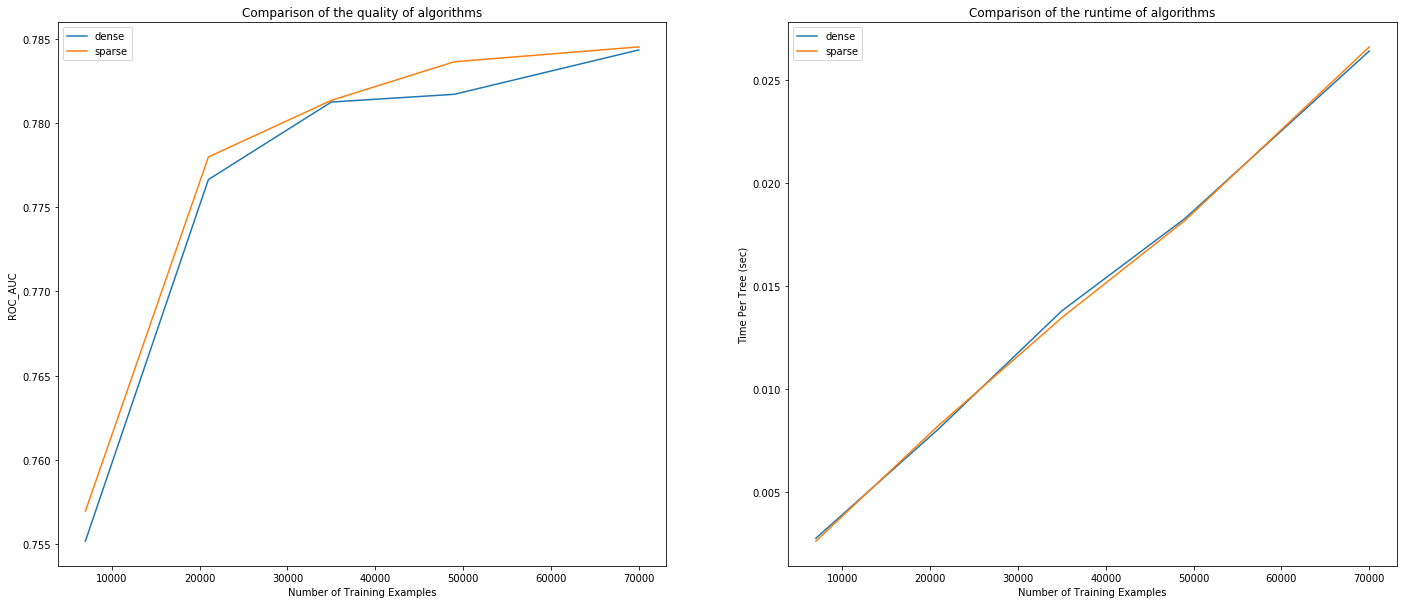

In [517]:
plot_sparse_vs_dense(*sparse_vs_dense(x_train, x_test, y_train, y_test))

## ML-100k

In [518]:
data = pd.read_csv('ml-100k/u.data', sep="\t", header=None, engine='python')
data = data.iloc[:50000]
data.columns = ["user_id", "item_id", "rating", "timestamp"]
data.drop(["timestamp"], axis=1, inplace=True)

data_one_hot = pd.get_dummies(data, 
                              columns=['user_id', 'item_id'], 
                              sparse=False)

data_one_hot_sparse = pd.get_dummies(data, 
                                     columns=['user_id', 'item_id'], 
                                     sparse=True)

print('Memory usage of dense:', get_memory_usage(data_one_hot))
print('Memory usage of sparse:', get_memory_usage(data_one_hot_sparse))

Memory usage of dense: 112.53 mb
Memory usage of sparse: 0.86 mb


In [519]:
y = data_one_hot['rating'] > 4
x = data_one_hot[data_one_hot.columns.difference(['rating'])] 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

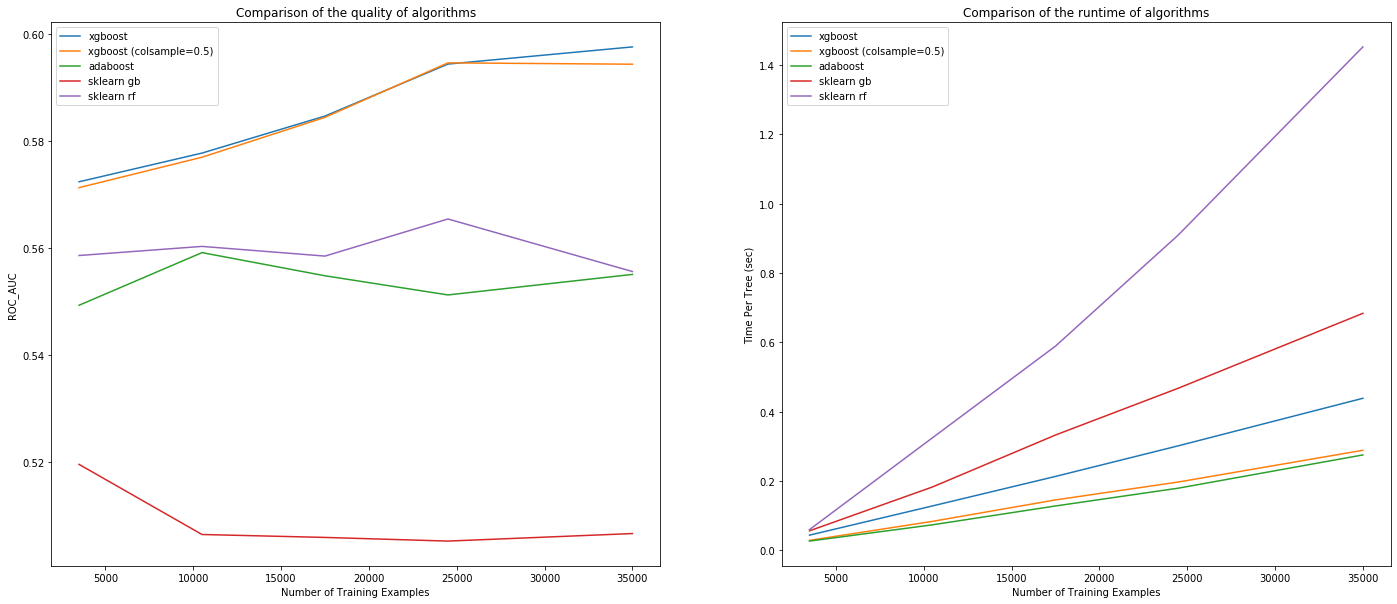

In [520]:
plot_results(*experiment(x_train, x_test, y_train, y_test))

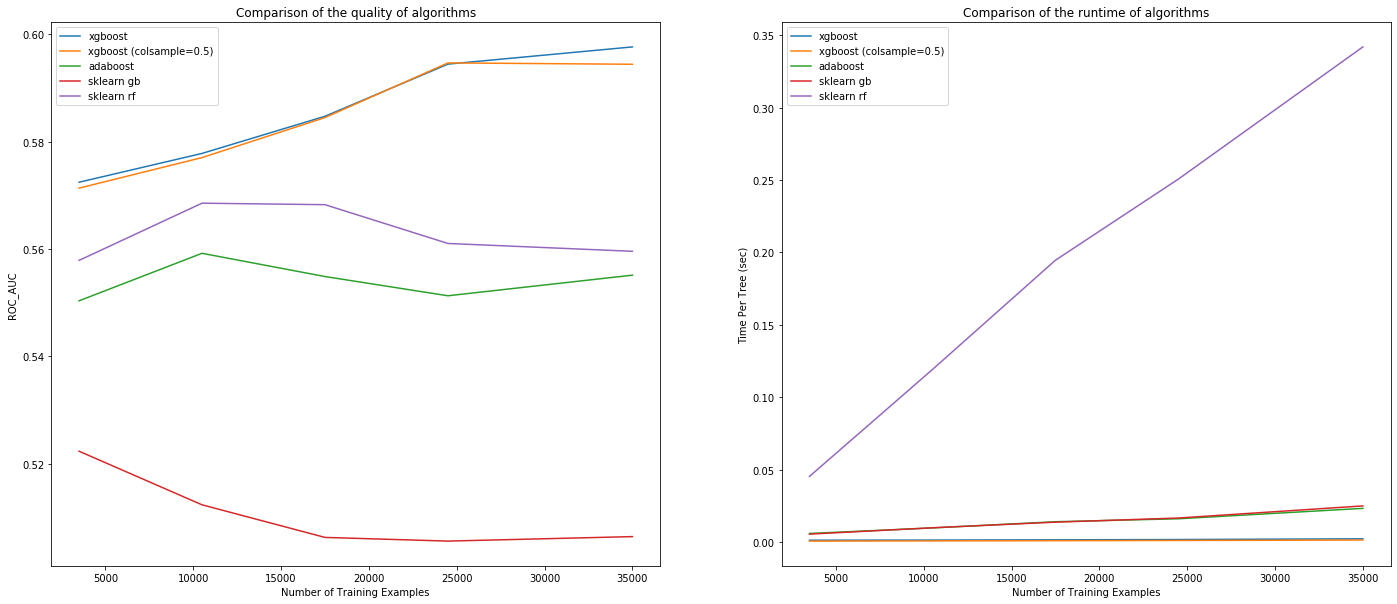

In [521]:
plot_results(*experiment(*to_sparse(x_train, x_test), y_train, y_test))

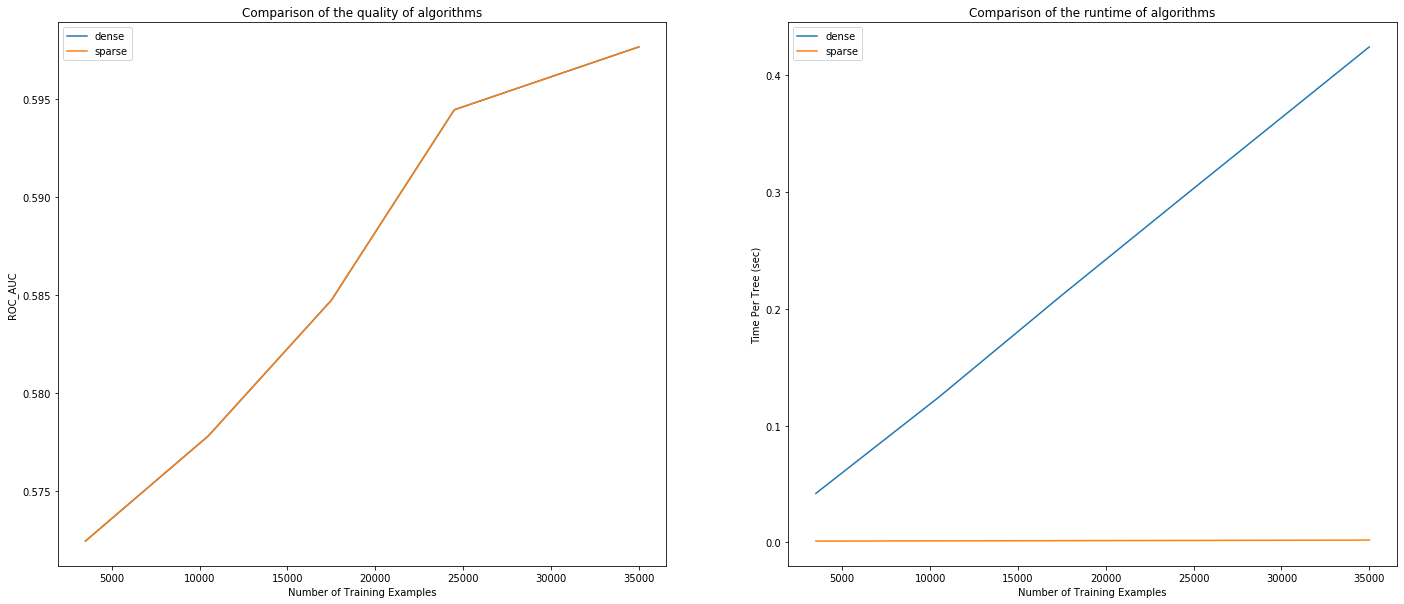

In [522]:
plot_sparse_vs_dense(*sparse_vs_dense(x_train, x_test, y_train, y_test))

## Ranking

In [526]:
def dcg_score(y_true, y_score):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order)
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score):
    best = dcg_score(y_true, y_true)
    actual = dcg_score(y_true, y_score)
    
    return actual / best


def ndcg_queries_score(y_true, y_score, groups):
    res = 0.0
    pos = 0
    
    for size in groups:
        res += ndcg_score(y_true[pos: pos + size], y_score[pos: pos + size])
        pos += size
    
    return res / len(groups)

In [536]:
def xgb_fit_eval_rank(x_train, x_test, y_train, y_test):
    
    train_mat = xgb.DMatrix(x_train, label=y_train)
    train_mat.set_group(train_groups)

    test_mat = xgb.DMatrix(x_test, label=y_test)
    test_mat.set_group(test_groups)
    
    curr_time = time.time()
    model = xgb.train({'objective': 'rank:pairwise', 
                 'silent' : 1,
                 'n_estimators': 100}, 
                train_mat)

    
    end_time = (time.time() - curr_time) / 100
    
    predict = ndcg_score(y_test, model.predict(test_mat))
    
    return predict, end_time


def xgb_fit_eval_rank_colsample(x_train, x_test, y_train, y_test):
    
    train_mat = xgb.DMatrix(x_train, label=y_train)
    train_mat.set_group(train_groups)

    test_mat = xgb.DMatrix(x_test, label=y_test)
    test_mat.set_group(test_groups)
    
    curr_time = time.time()
    
    model = xgb.train({'objective': 'rank:pairwise', 
                       'silent' : 1,
                       'n_estimators': 100,
                      'colsample_bytree': 0.5}, 
                train_mat)

    
    end_time = (time.time() - curr_time) / 100
    
    predict = ndcg_score(y_test, model.predict(test_mat))
    
    return predict, end_time

def cat_fit_eval_rank(x_train, x_test, y_train, y_test):
    
    train_mat = cat.Pool(x_train, label=y_train, 
                         group_id=df[:len(df_train)].query_id.to_numpy())
    test_mat = cat.Pool(x_test, label=y_test, 
                        group_id=df[len(df_train):].query_id.to_numpy())
    
    curr_time = time.time()
    model = cat.train(pool=train_mat, 
                  params={'loss_function' : 'PairLogit', 
                          'eval_metric' : 'NDCG',
                          'n_estimators': 100,
                          'verbose' : 0})
    
    end_time = (time.time() - curr_time) / 100
    
    predict = ndcg_score(y_test, model.predict(test_mat))
    
    return predict, end_time

def model_fit_eval_rank(x_train, x_test, y_train, y_test, model_type=None):
    
    curr_time = time.time()
    model = model_type(n_estimators=100)
    model.fit(x_train, y_train)
    
    end_time = (time.time() - curr_time) / 100
    
    predict = ndcg_score(y_test, model.predict(x_test))
    
    return predict, end_time

In [537]:
df = pd.read_csv('ranking.csv')
values = np.unique(df['query_id'].values)
split_pos = np.argwhere(
    df['query_id'].values == values[int(len(values) * 0.7)])[0][0]

df_train = df[:split_pos]
df_test = df[split_pos:]

train_groups = df_train.groupby('query_id').count()['relevance'].values
test_groups = df_test.groupby('query_id').count()['relevance'].values

In [538]:
y_train = df_train['relevance'].to_numpy()
y_test  = df_test['relevance'].to_numpy()

del df_train['relevance']
del df_test['relevance']

del df_train['query_id']
del df_test['query_id']

del df_train['org_id']
del df_test['org_id']

x_train = df_train.to_numpy()
x_test  = df_test.to_numpy()

In [539]:
result = dict()

result['Algorithm'] = []
result['Time Per Tree (sec)'] = []
result['NDCG'] = []

res = xgb_fit_eval_rank(x_train, x_test, y_train, y_test)
result['Algorithm'].append('xgboost')
result['Time Per Tree (sec)'].append(res[1])
result['NDCG'].append(res[0])

res = xgb_fit_eval_rank_colsample(x_train, x_test, y_train, y_test)
result['Algorithm'].append('xgboost (colsample=0.5)')
result['Time Per Tree (sec)'].append(res[1])
result['NDCG'].append(res[0])

res = cat_fit_eval_rank(x_train, x_test, y_train, y_test)
result['Algorithm'].append('catboost')
result['Time Per Tree (sec)'].append(res[1])
result['NDCG'].append(res[0])

res = model_fit_eval_rank(x_train, x_test, y_train, y_test, 
                          model_type=GradientBoostingRegressor)
result['Algorithm'].append('sklearn')
result['Time Per Tree (sec)'].append(res[1])
result['NDCG'].append(res[0])

df_res = pd.DataFrame(result)

In [545]:
df_res.sort_values(['NDCG'], ascending=False).reset_index(drop=True).head()

Algorithm  Time Per Tree (sec)      NDCG
0                 catboost             0.020190  0.791211
1  xgboost (colsample=0.5)             0.009083  0.778091
2                  xgboost             0.012623  0.774577
3                  sklearn             0.024981  0.702211

In [546]:
df_res.sort_values(['Time Per Tree (sec)']).reset_index(drop=True).head()

Algorithm  Time Per Tree (sec)      NDCG
0  xgboost (colsample=0.5)             0.009083  0.778091
1                  xgboost             0.012623  0.774577
2                 catboost             0.020190  0.791211
3                  sklearn             0.024981  0.702211